# Segundo intento de modelo

Fresno II: sin las columnas de bert/pca

In [ ]:
## Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone


In [2]:
## Cargar dataset

df = pd.read_csv("../data/dataCardsclean.csv")

## Train Test

Preparo los grupos de entrenamiento, validación y predicción.
Me quito los de 2025 porque mi intención es predecir esos sin que haya muestra de ellos durante el train.

In [3]:
# 1. Separar por año
df_future = df[df['released_year'] == 2025].copy()
df_past = df[df['released_year'] < 2025].copy()

# 2. Definir target
target = 'log_price'

In [4]:

# ------------------------------
# 2. Features a escalar
numeric_features = [
    'cmc', 'edhrec_rank', 'released_year', 'keyword_count',
    'mana_produced_count', 'power_num', 'toughness_num',
    'rarity_labeled', "legal_standard", "legal_pioneer",
    "legal_modern", "legal_legacy", "legal_vintage",
    "legal_commander", "legal_pauper"
]

scaler = MinMaxScaler()
df_past[numeric_features] = scaler.fit_transform(df_past[numeric_features])
df_future[numeric_features] = scaler.transform(df_future[numeric_features])

# ------------------------------
# 3. Split de entrenamiento
X_past = df_past.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_past = df_past[target]
X_future = df_future.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_future = df_future[target]

X_train, X_test, y_train, y_test = train_test_split(X_past, y_past, test_size=0.2, random_state=42)

# ------------------------------
# 4. Dividir por precio
def split_by_price(X, y):
    mask_cheap = y < 4
    return {
        'cheap': (X[mask_cheap], y[mask_cheap]),
        'expensive': (X[~mask_cheap], y[~mask_cheap])
    }

train_split = split_by_price(X_train, y_train)
test_split = split_by_price(X_test, y_test)
future_split = split_by_price(X_future, y_future)



In [5]:
# ------------------------------
# 5. Modelos y resultados

model_defs = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

results = []
trained_models = {'cheap': {}, 'expensive': {}} 

for name, model in model_defs.items():
    for label in ['cheap', 'expensive']:
        Xtr, ytr = train_split[label]
        Xte, yte = test_split[label]
        Xfu, yfu = future_split[label]
        
        model_clone = clone(model)
        model_clone.fit(Xtr, ytr)
        
        pred_train = model_clone.predict(Xtr)
        pred_test = model_clone.predict(Xte)
        pred_future = model_clone.predict(Xfu)

        mae_train = mean_absolute_error(np.expm1(ytr), np.expm1(pred_train))
        mae_test = mean_absolute_error(np.expm1(yte), np.expm1(pred_test))
        mae_future = mean_absolute_error(np.expm1(yfu), np.expm1(pred_future))

        results.append({
            'model': name,
            'group': label,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'mae_2025': mae_future
        })

        trained_models[label][name] = model_clone

# 21m 13s

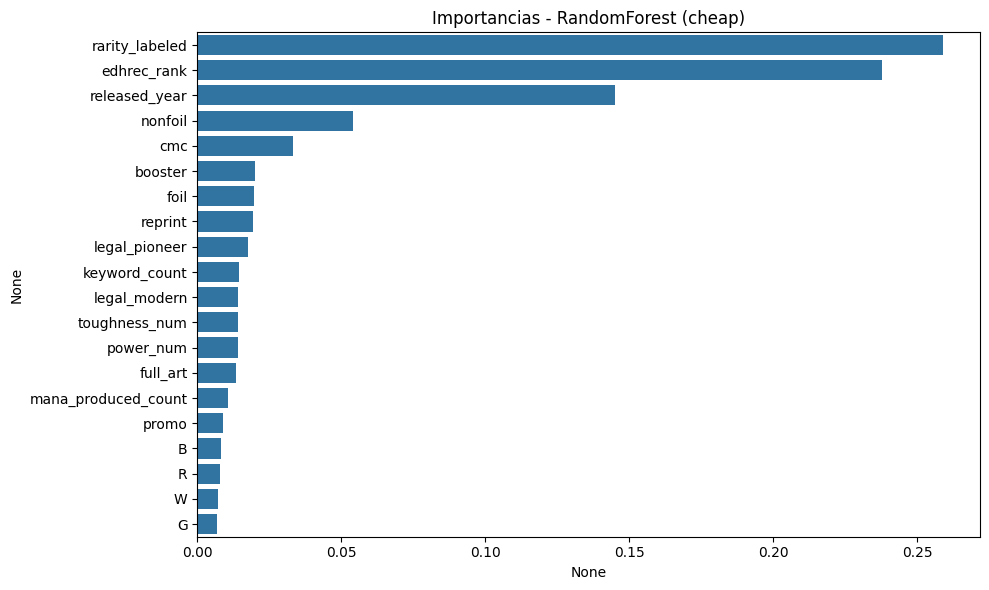

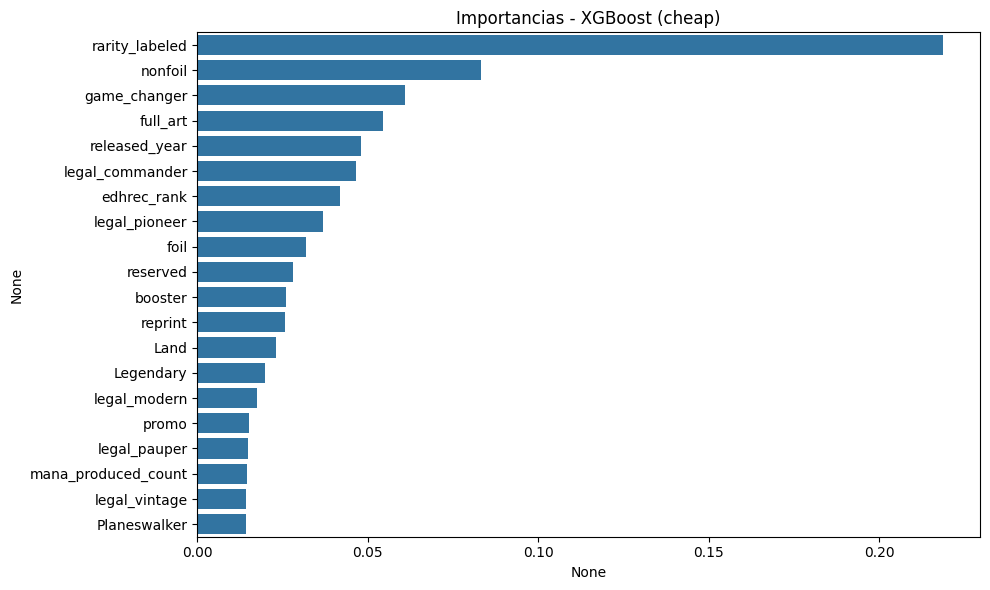

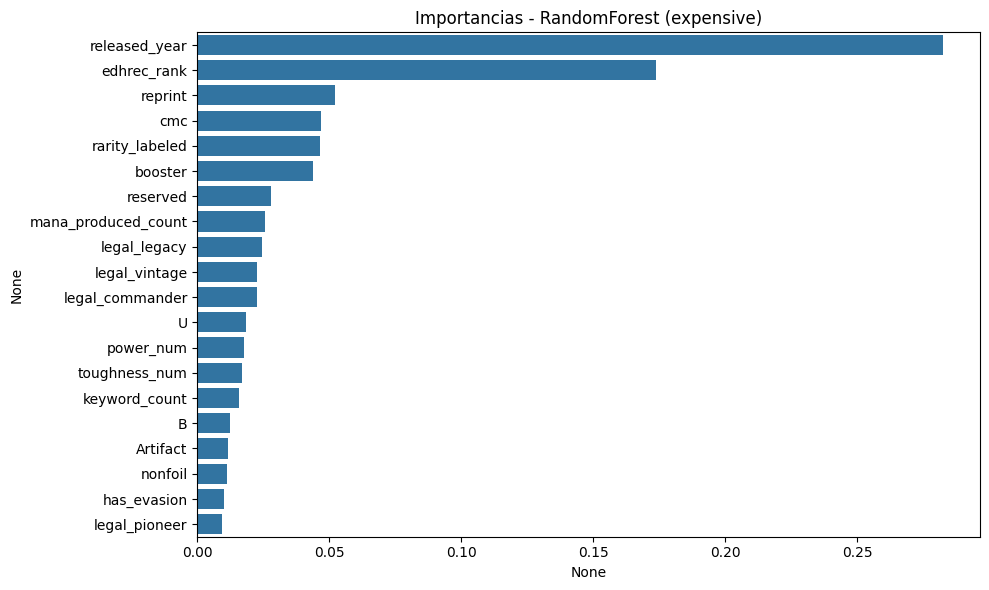

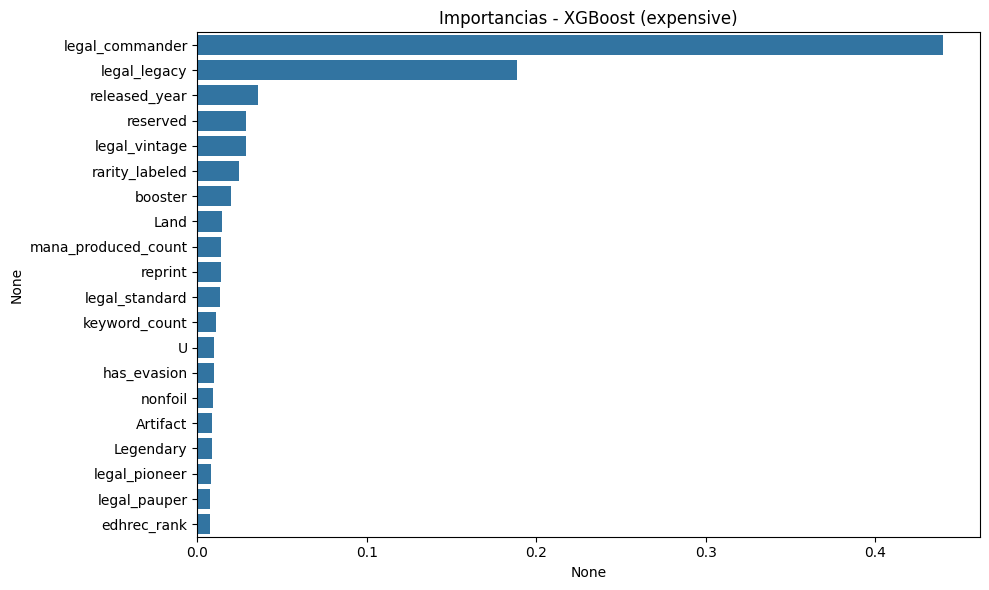

In [6]:
for group in ['cheap', 'expensive']:
    X_train, _ = train_split[group]
    
    for model_name, model in trained_models[group].items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            features = X_train.columns
            feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

            # Gráfico
            plt.figure(figsize=(10, 6))
            sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
            plt.title(f"Importancias - {model_name} ({group})")           
            plt.tight_layout()
            plt.show()
        else:
            print(f"{model_name} ({group}) no tiene feature_importances_")


In [7]:
# ------------------------------
# 6. Resultados
df_results = pd.DataFrame(results)
print(df_results)


          model      group   mae_train    mae_test    mae_2025
0  RandomForest      cheap    0.592123    1.210878    2.054827
1  RandomForest  expensive  186.776254  318.853426  145.311279
2       XGBoost      cheap    1.129213    1.243254    2.134164
3       XGBoost  expensive  149.443227  287.432894  182.428168


In [8]:
df_results.to_csv("../data/resultadosModelos_2.csv", index=False)

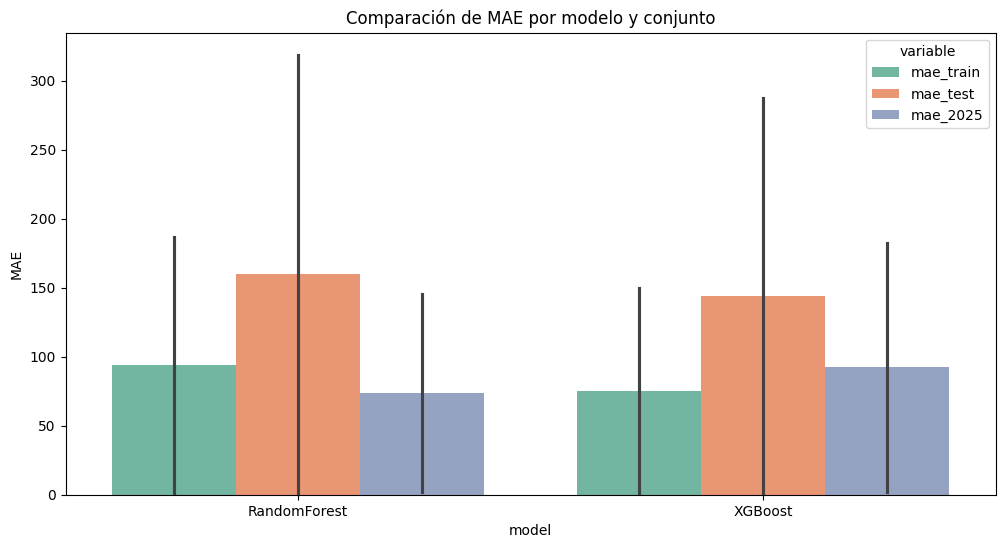

In [9]:
# ------------------------------
# 7. Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.melt(id_vars=['model', 'group'], value_vars=['mae_train', 'mae_test', 'mae_2025']),
            x='model', y='value', hue='variable', palette='Set2')
plt.title("Comparación de MAE por modelo y conjunto")
plt.ylabel("MAE")
plt.show()